In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import accuracy_score, precision_score, recall_score,confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from time import time
from copy import deepcopy
from scipy.optimize import fmin
from sklearn.metrics import roc_auc_score
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('precision', 4)

In [187]:
from scoring.db import read_sql, to_sql
from scoring.PSI import psi, psi_comparison_chart     ,psi_hist 

In [4]:
import sklearn

In [5]:
import costcla as cc

### Get Data

In [16]:
from costcla.datasets import load_bankmarketing#, load_creditscoring1, load_creditscoring2

data_b = load_bankmarketing()
#data_cs1 = load_creditscoring1()
#data_cs2 = load_creditscoring2()

In [609]:
data_b.cost_mat

array([[ 1.        , 13.19730655,  1.        ,  0.        ],
       [ 1.        ,  1.        ,  1.        ,  0.        ],
       [ 1.        ,  1.        ,  1.        ,  0.        ],
       ...,
       [ 1.        , 35.19487024,  1.        ,  0.        ],
       [ 1.        ,  4.11376611,  1.        ,  0.        ],
       [ 1.        , 18.29640586,  1.        ,  0.        ]])

In [73]:
data_card = pd.read_csv('data_card.csv', sep = ';')
data_cash= pd.read_csv('data_cash.csv', sep = ';')
data_pos = pd.read_csv('data_pos.csv', sep = ';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (274) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [74]:
full_data = pd.concat([data_card, data_cash, data_pos])
full_data = full_data.sample(frac=1).reset_index(drop=True)
full_data.shape

(178798, 293)

In [101]:
full_data = full_data.dropna()

In [102]:
for i in rules:
    if sum(full_data[i].isnull()) != 0:
        print(i)
        print(sum(full_data[i].isnull()))

In [91]:
full_data.head()

,SK_APPLICATION,SK_DATE_DECISION,SK_CONTRACT_TYPE,DEF_3_30,R1_11,R1_12,R1_13,R1_14,R1_15,R1_16,R1_17,R1_18,R1_19,R1_20,R1_21,R2_11,R2_12,R2_13,R2_14,R2_15,R2_16,R2_17,R2_18,R2_19,R2_20,R2_21,R2_22,R2_23,R2_24,R2_25,R2_26,R2_27,R2_28,R2_29,R2_30,R2_31,R2_32,R2_33,R2_34,R2_35,R2_36,R2_37,R2_38,R6_1,R6_2,R1_2001,R1_2002,R2_1001,R2_1002,R2_1003,R2_1004,R2_1005,R2_1006,R2_1007,R2_1008,R2_1009,R2_1010,R2_2001,R2_2002,R2_2003,R2_2004,R2_3001,R2_3002,R4_1001,R1_901,R2_901,R2_902,R2_903,R2_904,R2_905,R2_906,R2_907,R2_908,R2_909,R2_910,R2_911,R2_912,R2_913,R2_914,R2_915,R2_916,R2_917,R2_918,R2_919,R2_920,R2_921,R2_922,R2_923,R2_924,R2_925,R2_926,R2_927,R2_928,R2_929,R2_930,R2_931,R2_932,R2_933,R2_934,R2_935,R2_936,R2_937,R2_938,R2_939,R2_940,R2_941,R2_942,R2_943,R2_944,R2_945,R2_946,R2_947,R2_948,R2_949,R2_950,R2_951,R2_952,R2_953,R2_954,R3_901,R3_902,R3_903,R8_901,R8_902,R5_1,R5_2,R5_3,R5_4,R1_41,R1_42,R2_41,R2_42,CNT_RULE_1,CNT_RULE_2,CNT_RULE_3,CNT_RULE_4,CNT_RULE_5,CNT_RULE_6,CNT_RULE_7,CNT_RULE_8,CNT_RULE_9,CNT_RULE_10,CNT_RULE_11,CNT_RULE_12,CNT_RULE_13,CNT_RULE_14,CNT_RULE_15,CNT_RULE_16,CNT_RULE_17,CNT_RULE_18,CNT_RULE_19,CNT_RULE_20,CNT_RULE_21,CNT_RULE_22,CNT_RULE_23,CNT_RULE_24,CNT_RULE_25,CNT_RULE_26,CNT_RULE_27,CNT_RULE_28,CNT_RULE_29,CNT_RULE_30,CNT_RULE_31,CNT_RULE_32,CNT_RULE_33,CNT_RULE_34,CNT_RULE_35,CNT_RULE_36,CNT_RULE_37,CNT_RULE_38,CNT_RULE_39,CNT_RULE_40,CNT_RULE_41,CNT_RULE_42,CNT_RULE_43,CNT_RULE_44,CNT_RULE_45,CNT_RULE_46,CNT_RULE_47,CNT_RULE_48,CNT_RULE_49,CNT_RULE_50,CNT_RULE_51,CNT_RULE_52,CNT_RULE_53,CNT_RULE_54,CNT_RULE_55,CNT_RULE_56,CNT_RULE_57,CNT_RULE_58,CNT_RULE_59,CNT_RULE_60,CNT_RULE_61,CNT_RULE_62,CNT_RULE_63,CNT_RULE_64,CNT_RULE_65,CNT_RULE_66,CNT_RULE_67,CNT_RULE_68,CNT_RULE_69,CNT_RULE_70,CNT_RULE_71,CNT_RULE_72,CNT_RULE_73,CNT_RULE_74,CNT_RULE_75,CNT_RULE_76,CNT_RULE_77,CNT_RULE_78,CNT_RULE_79,CNT_RULE_80,CNT_RULE_81,CNT_RULE_82,CNT_RULE_83,CNT_RULE_84,CNT_RULE_85,CNT_RULE_86,CNT_RULE_87,CNT_RULE_88,CNT_RULE_89,CNT_RULE_90,CNT_RULE_91,CNT_RULE_92,CNT_RULE_93,CNT_RULE_94,CNT_RULE_95,CNT_RULE_96,CNT_RULE_97,CNT_RULE_98,CNT_RULE_99,CNT_RULE_100,CNT_RULE_101,CNT_RULE_102,CNT_RULE_103,CNT_RULE_104,CNT_RULE_105,CNT_RULE_106,CNT_RULE_107,CNT_RULE_108,CNT_RULE_109,CNT_RULE_110,CNT_RULE_111,CNT_RULE_112,CNT_RULE_113,CNT_RULE_114,CNT_RULE_115,CNT_RULE_116,CNT_RULE_117,CNT_RULE_118,CNT_RULE_119,CNT_RULE_120,CNT_RULE_121,CNT_RULE_122,CNT_RULE_123,CNT_RULE_124,CNT_RULE_125,CNT_RULE_126,CNT_RULE_127,CNT_RULE_128,CNT_RULE_129,CNT_RULE_130,CNT_RULE_131,CNT_RULE_132,CNT_RULE_133,CNT_RULE_134,CNT_RULE_135,CNT_RULE_136,CNT_RULE_137,CNT_RULE_138,CNT_RULE_139,R2_44,R2_81,R2_82,R1_81,R1_601,R1_602,R1_603,R1_604,R1_605,R2_601,R2_602,R2_603,R2_604,R2_605,R2_606,R2_607,R2_608,R2_609,TP,FP,TN,FN
0,133185479,20170811,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0434,0.2463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.3481,0.6557,0.1126,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,2.06,1.39,0,9.54
1,144823119,20180303,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,3.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,

In [78]:
for i in full_data.columns:
    if full_data[i].dtype == object:
        full_data[i] = full_data[i].str.replace(',', '.')
        full_data[i] = full_data[i].astype(float)

In [254]:
full_data['MONTH_DECISION'] = full_data.SK_DATE_DECISION.apply(lambda x:x//100)
full_data["QUARTER_DECISION"] = full_data["MONTH_DECISION"].apply(lambda x: 100*(x//100) + ((x%100-1)//3)+1)

In [79]:
other = ['SK_APPLICATION', 'SK_DATE_DECISION', 'MONTH_DECISION', 'SK_CONTRACT_TYPE', 'DEF_3_30', 'TP', 'FP', 'TN', 'FN']

In [80]:
rules = list(set(full_data.columns)-set(other))

In [81]:
len(rules)

285

In [103]:
data = full_data[rules].to_numpy()
target = full_data['DEF_3_30'].to_numpy()
cost_mat = full_data[['FP', 'FN', 'TP', 'TN']].to_numpy()

#### Testing costcla datasets

In [104]:
costcla_datasets = []
for l, d in zip(['bank'],[data_b]):  #[,'cs1','cs2'] , [,data_cs1,data_cs2]
    costcla_datasets.append({'label' : l, 'X' : d.data, 'y' : d.target, 'cost_mat' : d.cost_mat})
    print(l,d.data.shape,d.target.shape,d.cost_mat.shape)

bank (37931, 32) (37931,) (37931, 4)


In [105]:
my_datasets = []
my_datasets.append({'label' : 'mine', 'X' : data, 'y' : target, 'cost_mat' : cost_mat})

In [106]:
sum(target)

11257

In [213]:
res = []

In [214]:
my_algorithms = ['CS1','CG1','C3'] # 'CS2','CG2'

costcla_algorithms = [cc.models.CostSensitiveDecisionTreeClassifier(),
                      cc.models.CostSensitiveRandomPatchesClassifier(n_estimators=25, combination='weighted_voting')]
costcla_labels = ['CSDT','CSRP']

sk_algorithms = [AdaBoostClassifier()]
sk_labels = ['AB']

scores_train, scores_test = test_classifiers(my_datasets,
                 my_algorithms, costcla_algorithms, costcla_labels, sk_algorithms, sk_labels,
                 my_BMR = True, costcla_BMR = True, sk_BMR = True,
                 my_Platt = True, costcla_Platt = True, sk_Platt = True,
                 my_Iso = True, costcla_Iso = True, sk_Iso = True)

Clf        Time  Train  Test      F1
mine ================================
     CS1:    8.8  0.076  0.078  0.191


/opt/conda/lib/python3.6/site-packages/costcla/models/directcost.py:101: RuntimeWarning: divide by zero encountered in true_divide
  t_bmr = (cost_mat[:, 0] - cost_mat[:, 3]) / (cost_mat[:, 1] - cost_mat[:, 3] - cost_mat[:, 2] + cost_mat[:, 0])
/opt/conda/lib/python3.6/site-packages/costcla/models/directcost.py:101: RuntimeWarning: invalid value encountered in true_divide
  t_bmr = (cost_mat[:, 0] - cost_mat[:, 3]) / (cost_mat[:, 1] - cost_mat[:, 3] - cost_mat[:, 2] + cost_mat[:, 0])


 CS1-BMR:    0.6  0.237  0.245  0.141
 CS1-Pla:    0.6  0.241  0.240  0.133
 CS1-Iso:    0.6  0.246  0.254  0.141
     CG1:    8.8  0.081  0.077  0.188
 CG1-BMR:    0.6  0.239  0.238  0.139
 CG1-Pla:    0.6  0.239  0.242  0.134
 CG1-Iso:    0.6  0.248  0.247  0.139
      C3:    5.2  0.076  0.078  0.191


/opt/conda/lib/python3.6/site-packages/costcla/models/directcost.py:101: RuntimeWarning: divide by zero encountered in true_divide
  t_bmr = (cost_mat[:, 0] - cost_mat[:, 3]) / (cost_mat[:, 1] - cost_mat[:, 3] - cost_mat[:, 2] + cost_mat[:, 0])
/opt/conda/lib/python3.6/site-packages/costcla/models/directcost.py:101: RuntimeWarning: invalid value encountered in true_divide
  t_bmr = (cost_mat[:, 0] - cost_mat[:, 3]) / (cost_mat[:, 1] - cost_mat[:, 3] - cost_mat[:, 2] + cost_mat[:, 0])


  C3-BMR:    0.3  0.225  0.228  0.132
  C3-Pla:    0.3  0.235  0.234  0.130
  C3-Iso:    0.3  0.234  0.237  0.132
    CSDT:  933.0  0.154  0.107  0.210


/opt/conda/lib/python3.6/site-packages/costcla/models/directcost.py:101: RuntimeWarning: divide by zero encountered in true_divide
  t_bmr = (cost_mat[:, 0] - cost_mat[:, 3]) / (cost_mat[:, 1] - cost_mat[:, 3] - cost_mat[:, 2] + cost_mat[:, 0])
/opt/conda/lib/python3.6/site-packages/costcla/models/directcost.py:101: RuntimeWarning: invalid value encountered in true_divide
  t_bmr = (cost_mat[:, 0] - cost_mat[:, 3]) / (cost_mat[:, 1] - cost_mat[:, 3] - cost_mat[:, 2] + cost_mat[:, 0])


CSDT-BMR:    1.9  0.268  0.236  0.137
CSDT-Pla:    1.9  0.272  0.248  0.134
CSDT-Iso:    1.9  0.212  0.173  0.121
    CSRP: 3327.7  0.141  0.100  0.207


/opt/conda/lib/python3.6/site-packages/costcla/models/directcost.py:101: RuntimeWarning: divide by zero encountered in true_divide
  t_bmr = (cost_mat[:, 0] - cost_mat[:, 3]) / (cost_mat[:, 1] - cost_mat[:, 3] - cost_mat[:, 2] + cost_mat[:, 0])
/opt/conda/lib/python3.6/site-packages/costcla/models/directcost.py:101: RuntimeWarning: invalid value encountered in true_divide
  t_bmr = (cost_mat[:, 0] - cost_mat[:, 3]) / (cost_mat[:, 1] - cost_mat[:, 3] - cost_mat[:, 2] + cost_mat[:, 0])


CSRP-BMR:   38.6  0.322  0.260  0.154
CSRP-Pla:   38.6  0.327  0.266  0.155
CSRP-Iso:   38.6  0.306  0.229  0.175
      AB:   32.2  0.013  0.012  0.029


/opt/conda/lib/python3.6/site-packages/costcla/models/directcost.py:101: RuntimeWarning: divide by zero encountered in true_divide
  t_bmr = (cost_mat[:, 0] - cost_mat[:, 3]) / (cost_mat[:, 1] - cost_mat[:, 3] - cost_mat[:, 2] + cost_mat[:, 0])
/opt/conda/lib/python3.6/site-packages/costcla/models/directcost.py:101: RuntimeWarning: invalid value encountered in true_divide
  t_bmr = (cost_mat[:, 0] - cost_mat[:, 3]) / (cost_mat[:, 1] - cost_mat[:, 3] - cost_mat[:, 2] + cost_mat[:, 0])


  AB-BMR:    3.3  0.306  0.298  0.171
  AB-Pla:    3.3  0.316  0.307  0.168
  AB-Iso:    3.3  0.306  0.229  0.175


In [256]:
scores_train = scores_train.merge(full_data['QUARTER_DECISION', 'DEF_3_30'],
                                                      how = 'inner', left_index = True, right_index = True)
scores_test = scores_test.merge(full_data['QUARTER_DECISION', 'DEF_3_30'],
                                                      how = 'inner', left_index = True, right_index = True )

In [328]:

%matplotlib inline
import matplotlib.pyplot as plt


def psi(x, y, bins=10):
    """
    PSI metric for month y relatively to the month x
    """
    bins=sorted(np.percentile(x, np.linspace(0,100,bins)))
    
    freqs,bins=np.histogram(x, bins=bins)
    freqs=freqs*1.0/np.sum(freqs)
    
    freqs2, _=np.histogram(y, bins)
    freqs2=freqs2*1.0/np.sum(freqs2)
    
    freqs2 = np.ma.masked_equal(freqs2,0.0)
    
    ps=100*np.sum((freqs-freqs2)*np.log(freqs/freqs2))
    return ps

def psi_monthly(data, score, months, month_list):
    psi_score_monthly = []
    for i in month_list:
        psi_score_monthly.append(psi(data.loc[(data[score].notnull()) & \
                           (data[months] == month_list[0]), score], \
        data.loc[(data[score].notnull()) & (data[months] == i), score], bins=10))
        
    #print(psi_score_monthly)
    return psi_score_monthly

def psi_c(months, psi_array, labels_array, title='PSI', size=(15, 6)):

        plt.figure(figsize=size)
        plt.grid(zorder=0)
      
        X = np.linspace(0, len(months), len(months))
        X1 = np.linspace(0, len(months) + 1, len(months) + 1)
        plt.plot(X1, [0.1]*(len(X) + 1), 'black')
        plt.plot(X1, [0.25]*(len(X) + 1), 'r')

        for i in range(len(psi_array)):
            plt.bar(X - (1/float(len(psi_array)))*i, psi_array[i], width=1/float(len(psi_array)), label=labels_array[i],
                    zorder=3, alpha=0.5)
        #plt.bar(X, psi2,  width=0.5, color='r', label=label2, zorder=3)
        
        plt.title(title, fontsize=20)
        plt.xticks(X, ['201802', '201803', '201804', '201901', '201902', '201903', '201904', '202001'], rotation=45, fontsize=15)
        plt.xlim(0, len(months)+0.5)
        #plt.ylim(0, np.array(psi_array).max()+0.02 )
        plt.xlabel('Quarter', fontsize=15)
        plt.ylabel('PSI', fontsize=15)
        plt.legend(fontsize=15)

def psi_cust(data, scores, period = 'MONTH_DECISION'):
    month_list = sorted(data[period].unique())
    for score in scores:
        PSI_monthly = []
        PSI_monthly.append(psi_monthly(data, score, period,  month_list))
        psi_c(month_list, PSI_monthly, [score], title ='PSI:'+' '+score)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


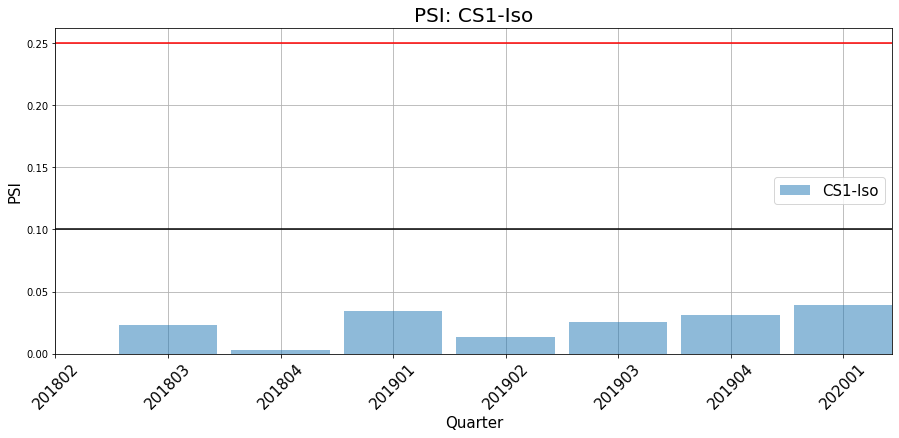

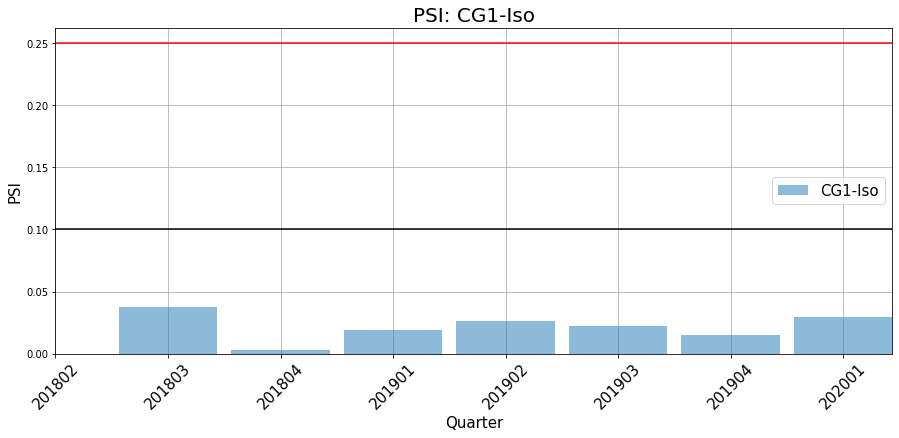

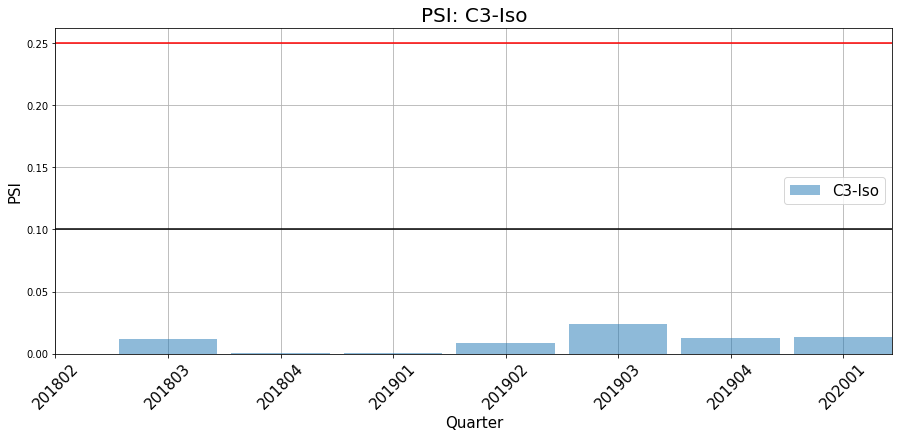

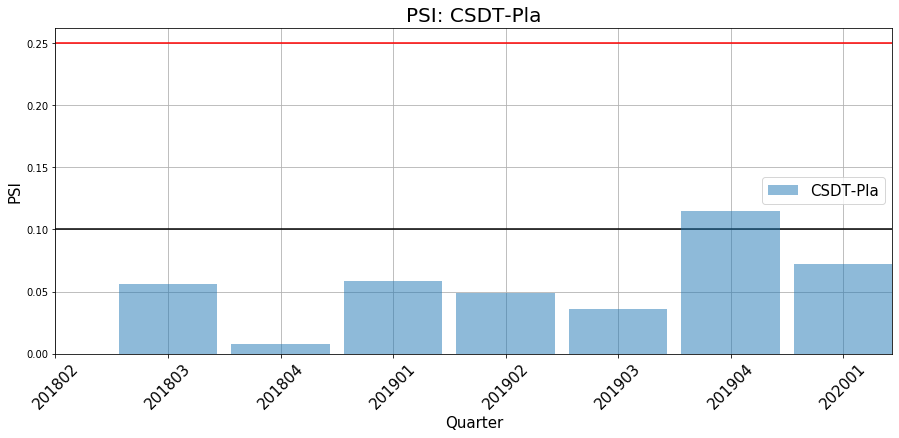

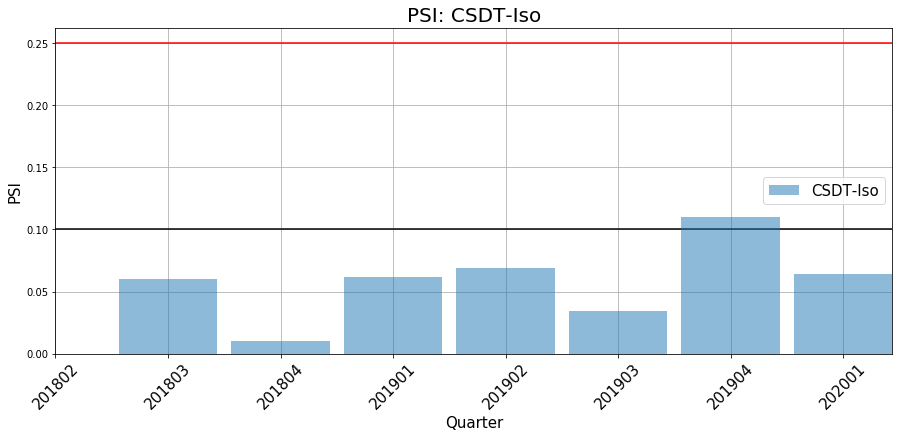

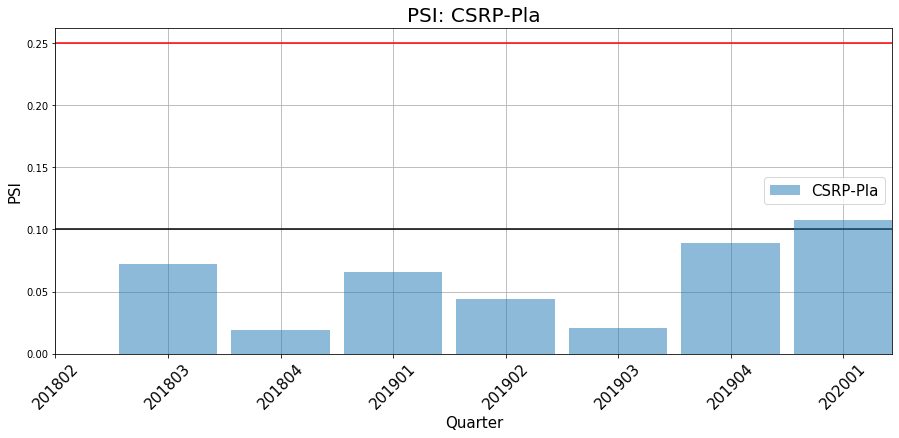

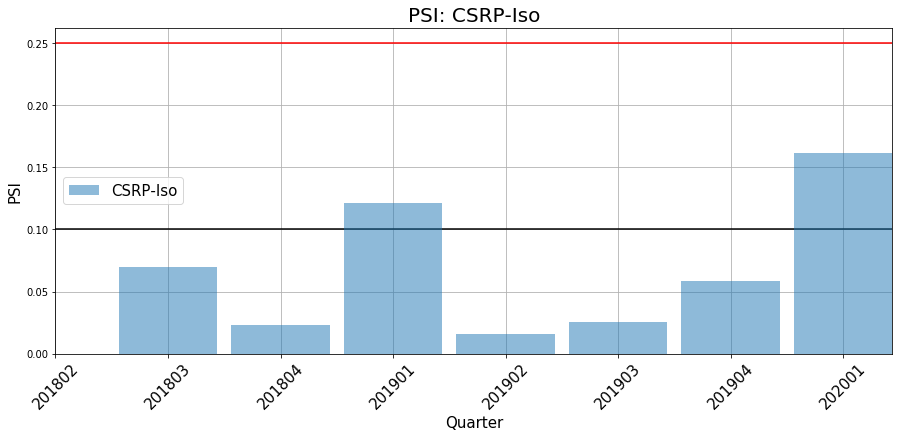

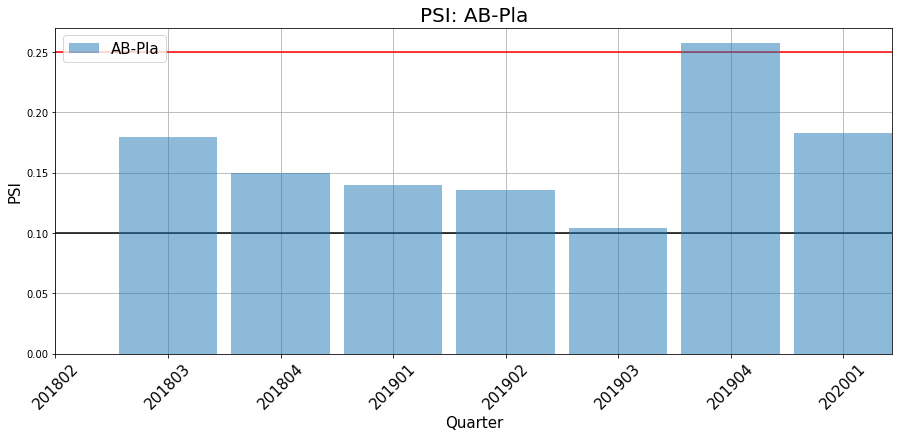

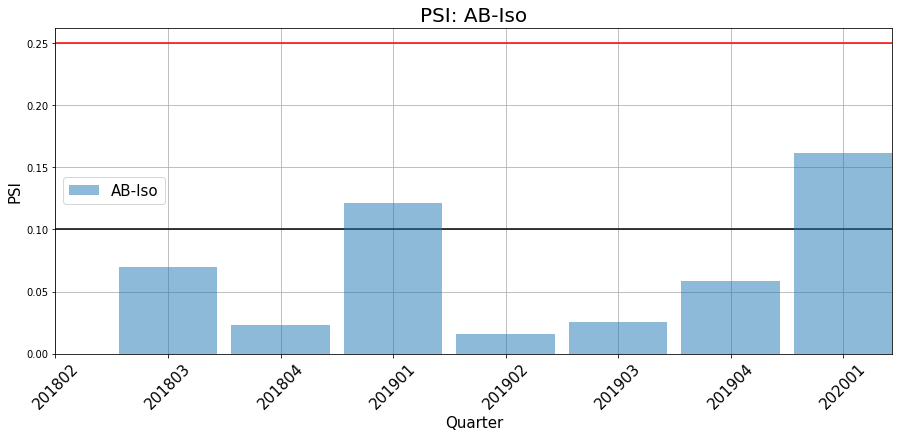

In [329]:
psi_cust(scores_test, ['CS1-Iso', 'CG1-Iso', 'C3-Iso', 
                       'CSDT-Pla', 'CSDT-Iso', 'CSRP-Pla', 'CSRP-Iso', 'AB-Pla', 'AB-Iso'], 
         period = 'QUARTER_DECISION')

In [315]:
for i in scores_test.columns:
    print(i)
    print(roc_auc_score(scores_test['DEF_3_30'], scores_test[i]))

CS1-BMR
0.6025417161267658
CS1-Iso
0.6025076558383466
CG1-BMR
0.60098319509011
CG1-Iso
0.600949515012637
C3-BMR
0.6005393209617911
C3-Iso
0.6005393209617911
CSDT-Pla
0.6008641487285137
CSDT-Iso
0.6009493563158944
CSRP-Pla
0.6010851048484319
CSRP-Iso
0.6011891265959055
AB-Pla
0.6016901183268967
AB-Iso
0.6011891265959055
MONTH_DECISION
0.633064838634302
QUARTER_DECISION
0.632168290643277
DEF_3_30
1.1


#### Analysis Datasets

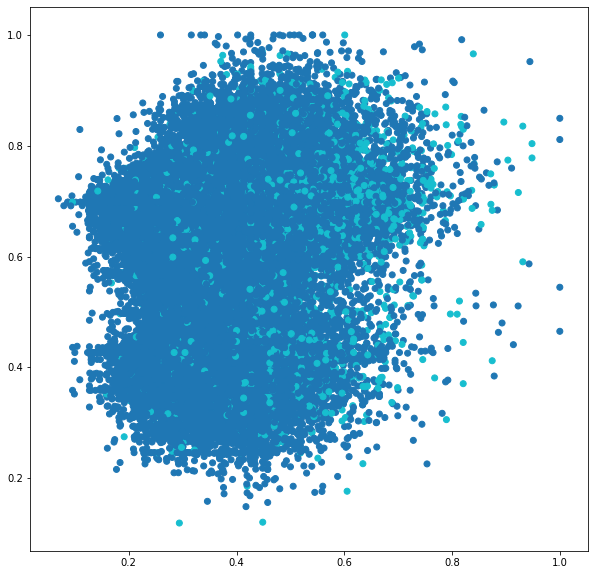

In [114]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 10)


for i,label in enumerate(['a']):
    df = my_datasets[0]
    plt.scatter(x = full_data[rules]['R2_44'], y = full_data[rules]['R2_81'], 
                c = full_data['DEF_3_30'], cmap = 'tab10')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  


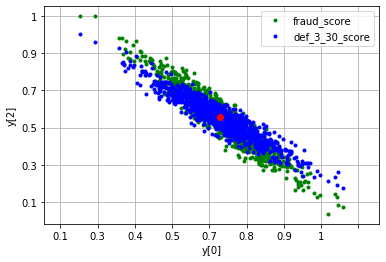

In [69]:
num_samples = 1000

# The desired mean values of the sample.
mu = np.array([0.55, 0.55, 0.55])

# The desired covariance matrix.
r = np.array([
        [  3.40, -2.75, -2.00],
        [ -2.75,  2.0,  1.50],
        [ -2.00,  1.50,  1.25]
    ])

# Generate the random samples.
y = np.random.multivariate_normal(mu, r, size=num_samples)


# Plot various projections of the samples.
fig, ax = plt.subplots()
plt.plot(2,2,1)
plt.plot(y[:,0], y[:,1], 'g.', label = 'fraud_score')
plt.plot(mu[0], mu[1], 'ro')
plt.ylabel('y[1]')
plt.axis('equal')
plt.grid(True)


plt.plot(2,2,3)
plt.plot(y[:,0], y[:,2], 'b.', label = 'def_3_30_score')
plt.plot(mu[0], mu[2], 'ro')
plt.xlabel('y[0]')
plt.ylabel('y[2]')
plt.axis('equal')
plt.grid(True)

ax.set_xticklabels([0, 0.1, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1])
ax.set_yticklabels([0, 0.1, 0.3, 0.5, 0.7, 0.9, 1])

plt.legend()
plt.show()

### Post processing

In [266]:
df_res = pd.DataFrame(res, columns = ['Clf','Time','Train','Test','F1'])

In [267]:
df_res

,Clf,Time,Train,Test,F1
0,CS1,8.8455,0.0763,0.0778,0.1915
1,CS1-BMR,0.6204,0.2368,0.2451,0.1411
2,CS1-Pla,0.6204,0.2408,0.2405,0.1331
3,CS1-Iso,0.6204,0.2458,0.2544,0.1410
4,CG1,8.8459,0.0813,0.0769,0.1881
5,CG1-BMR,0.6297,0.2385,0.2381,0.1388
6,CG1-Pla,0.6297,0.2395,0.2421,0.1341
7,CG1-Iso,0.6297,0.2481,0.2472,0.1395
8,C3,5.2411,0.0763,0.0778,0.1915
9,C3-BMR,0.3375,0.2246,0.2282,0.1323


In [268]:
df_res['Dataset'] = 'test'

In [269]:
# df_res.to_csv('results.csv',sep = ';', decimal = ',')

In [109]:
def asymmetry(y, cost_mat):
    C_FP, C_FN, C_TP, C_TN = cost_mat[:,0],cost_mat[:,1],cost_mat[:,2],cost_mat[:,3]
    C_neg = (C_FN - C_TN) / (C_FP - C_TN)
    C_pos = (C_TP - C_TN) / (C_FP - C_TN)
    b = C_neg - C_pos
    
    Pos = sum(y[y == 1])       #Number of positive training examples
    Neg = len(y) - Pos
    skew = C_FP * Neg / (C_FN * Pos + C_FP * Neg)  

    return np.mean(b), np.std(b), np.mean(skew)

In [270]:
for data in costcla_datasets:
    b_mean, b_var, skew = asymmetry(data['y'],data['cost_mat'])
    print('%7s %6.3f  %6.2f %6.3f' %(data['label'],b_mean, b_var, skew))
    print(len(data['y']), len(data['y'][data['y'] > 0])/ len(data['y']), data['X'].shape)
    
for data in my_datasets:
    b_mean, b_var, skew = asymmetry(data['y'],data['cost_mat'])
    print('%7s %6.3f  %6.2f %6.3f' %(data['label'],b_mean, b_var, skew))
    print(len(data['y']), len(data['y'][data['y'] > 0])/ len(data['y']), data['X'].shape)

   bank  9.306   19.90  0.590
37931 0.12620284200258364 (37931, 32)
   mine    nan     nan  0.549
171591 0.06560367385235823 (171591, 285)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


#### AdaMEC

In [271]:
def skew(cost_mat):
    C_FP, C_FN, C_TP, C_TN = cost_mat[:,0],cost_mat[:,1],cost_mat[:,2],cost_mat[:,3]
    return C_FP / (C_FN + C_FP)

data = my_datasets[0]

X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = train_test_split(
                        data['X'], data['y'], data['cost_mat'], test_size=0.33, random_state=0)

uncalAB = AdaBoostClassifier(algorithm="SAMME.R")

start = time()
uncalAB.fit(X_train, y_train)
end = time()

post_proc('uncal AB', end-start, y_train, uncalAB.predict(X_train),cost_mat_train, 
                           y_test,  uncalAB.predict(X_test), cost_mat_test)

calAB = CalibratedClassifierCV(uncalAB, cv="prefit", method="sigmoid")
start = time()
calAB.fit(X_train, y_train)
end = time()

post_proc('cal AB', end-start, y_train, calAB.predict(X_train),cost_mat_train, 
                               y_test,  calAB.predict(X_test), cost_mat_test)

y_pred_train = np.sign(calAB.predict_proba(X_train)[:,1] - skew(cost_mat_train))
y_pred_test  = np.sign(calAB.predict_proba(X_test)[:,1] - skew(cost_mat_test))

post_proc('cal AB', end-start, y_train, y_pred_train, cost_mat_train, 
                               y_test,  y_pred_test,  cost_mat_test)

uncal AB:   33.3  0.013  0.012  0.029
  cal AB:    1.7  0.010  0.009  0.025
  cal AB:    1.7  0.313  0.301  0.170


#### Analysis - Moon dataset

In [272]:
data = my_datasets[0]

X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = train_test_split(
        data['X'], data['y'], data['cost_mat'], test_size=0.33, random_state=0)
y_train_1 = np.array([1 if y > 0 else -1 for y in y_train])
y_test_1  = np.array([1 if y > 0 else -1 for y in y_test])

edab_CG1 = EDCS_AdaBoost(base_estimator = DecisionTreeClassifier(max_depth = 1), n_estimators = 100, cost_func = 'CG1')
edab_CG1.fit(X_train, y_train_1, cost_mat_train, verbose = False)

results(edab_CG1,X_train,y_train_1,cost_mat_train,X_test,y_test_1,cost_mat_test)

       Cost Savings Cost_N Cost_P
train: 73181.65 0.081 10112.34 63069.31
test : 34991.51 0.077 5080.19 29911.32
[[47881  5079]
 [ 2758   908]]
[[    0.    5080.19]
 [28590.18  1321.14]]


In [273]:
edab_CS1 = EDCS_AdaBoost(base_estimator = DecisionTreeClassifier(max_depth = 1), n_estimators = 100, cost_func = 'CS1')
edab_CS1.fit(X_train, y_train_1, cost_mat_train, verbose = False)
results(edab_CS1,X_train,y_train_1,cost_mat_train,X_test,y_test_1,cost_mat_test)

       Cost Savings Cost_N Cost_P
train: 73575.99 0.076 14416.29 59159.70
test : 34955.08 0.078 7103.74 27851.34
[[45867  7093]
 [ 2527  1139]]
[[    0.    7103.74]
 [26191.73  1659.61]]


In [274]:
edab_C3 = EDCS_AdaBoost(base_estimator = DecisionTreeClassifier(max_depth = 1), n_estimators = 100, cost_func = 'C3')
edab_C3.fit(X_train, y_train_1, cost_mat_train, verbose = False)
results(edab_C3,X_train,y_train_1,cost_mat_train,X_test,y_test_1,cost_mat_test)

       Cost Savings Cost_N Cost_P
train: 73575.99 0.076 14416.29 59159.70
test : 34955.08 0.078 7103.74 27851.34
[[45867  7093]
 [ 2527  1139]]
[[    0.    7103.74]
 [26191.73  1659.61]]


In [275]:
edab_CG1.fit_BMR(X_train, y_train_1)

pred_test  = edab_CG1.predict_BMR(X_test,cost_mat_test)
pred_train = edab_CG1.predict_BMR(X_train,cost_mat_train)
    
print('       Cost Savings Cost_N Cost_P')
cost, cost_N, cost_P = cost_loss(y_train_1, pred_train, cost_mat_train)
print('train: %.2f %.3f %.2f %.2f' %(cost, savings_score(y_train_1,pred_train,cost_mat_train), cost_N, cost_P))
cost, cost_N, cost_P = cost_loss(y_test_1, pred_test, cost_mat_test)
print('test : %.2f %.3f %.2f %.2f' %(cost, savings_score(y_test_1,pred_test,cost_mat_test), cost_N, cost_P))
print(confusion_matrix(y_test_1,pred_test))
print(cost_confusion_matrix(y_test_1,pred_test,cost_mat_test))

/opt/conda/lib/python3.6/site-packages/costcla/models/directcost.py:101: RuntimeWarning: divide by zero encountered in true_divide
  t_bmr = (cost_mat[:, 0] - cost_mat[:, 3]) / (cost_mat[:, 1] - cost_mat[:, 3] - cost_mat[:, 2] + cost_mat[:, 0])


       Cost Savings Cost_N Cost_P
train: 60657.84 0.239 17324.63 43333.21
test : 28881.13 0.238 8395.99 20485.14
[[36437 16523]
 [ 2160  1506]]
[[    0.    8395.99]
 [18354.21  2130.93]]


/opt/conda/lib/python3.6/site-packages/costcla/models/directcost.py:101: RuntimeWarning: invalid value encountered in true_divide
  t_bmr = (cost_mat[:, 0] - cost_mat[:, 3]) / (cost_mat[:, 1] - cost_mat[:, 3] - cost_mat[:, 2] + cost_mat[:, 0])


In [279]:
d = {'y' : y_test_1, 'C1' : edab_CS1.predict(X_test), 'C2' : edab_CG1.predict(X_test), 
     'C3' : edab_C3.predict(X_test), 'C2_ROC' : edab_CG1.predict_BMR(X_test,cost_mat_test),
     'C_FP' : cost_mat_test[:,0], 'C_FN' : cost_mat_test[:,1], 'C_TP' : cost_mat_test[:,2], 'C_TN' : cost_mat_test[:,3]}
df_an = pd.DataFrame(d)

/opt/conda/lib/python3.6/site-packages/costcla/models/directcost.py:101: RuntimeWarning: divide by zero encountered in true_divide
  t_bmr = (cost_mat[:, 0] - cost_mat[:, 3]) / (cost_mat[:, 1] - cost_mat[:, 3] - cost_mat[:, 2] + cost_mat[:, 0])


In [282]:
c_max = df_an.C_FN.max()
print('Total', df_an.shape[0], 'examples, c_max =', c_max)
n =11

c_left = 0
k_tot = 0
fig = []

for i in range(0,n-1):
    c_right = c_left + c_max / n
    df_sub = df_an[df_an.C_FN >= c_left][df_an.C_FN < c_right]
    k = df_sub.shape[0]
    k_tot += k
    err_C1 = sum(df_sub.C1 != df_sub.y) / k
    err_C2 = sum(df_sub.C2 != df_sub.y) / k
    err_C3 = sum(df_sub.C3 != df_sub.y) / k
    err_C2_ROC = sum(df_sub.C2_ROC != df_sub.y) / k
    
    cm = df_sub[['C_FP','C_FN','C_TP','C_TN']].values
    
    cost_C1, neg_C1, pos_C1 = cost_loss(df_sub.y, df_sub.C1, cm)
    cost_C2, neg_C2, pos_C2 = cost_loss(df_sub.y, df_sub.C2, cm)
    cost_C3, neg_C3, pos_C3 = cost_loss(df_sub.y, df_sub.C3, cm)
    cost_C2_ROC, neg_C2_ROC, pos_C2_ROC = cost_loss(df_sub.y, df_sub.C2_ROC, cm)
    
    tot_cost = df_sub.C_FN.sum()
    fig.append([k, round(c_left,3), round((c_left+c_right)/2,3), round(c_right,3),
                err_C1,  err_C2,  err_C3,  err_C2_ROC, tot_cost,
                cost_C1, cost_C2, cost_C3, cost_C2_ROC,
                neg_C1,  neg_C2,  neg_C3,  neg_C2_ROC,
                pos_C1,  pos_C2,  pos_C3,  pos_C2_ROC])
    
    c_left = c_right

df_fig = pd.DataFrame(fig, columns = ['No_of_ex','C_FN_left','mean(C_FN)','C_FN_right',
                                      'EDAB.C1','EDAB.C2','EDAB.C3','EDAB.C2-ROC', 'tot_cost',
                                      'loss.C1','loss.C2','loss.C3','loss.C2-ROC',
                                      'neg.C1','neg.C2','neg.C3','neg.C2-ROC',
                                      'pos.C1','pos.C2','pos.C3','pos.C2-ROC'])
df_fig.head(10)

Total 56626 examples, c_max = 20.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


,No_of_ex,C_FN_left,mean(C_FN),C_FN_right,EDAB.C1,EDAB.C2,EDAB.C3,EDAB.C2-ROC,tot_cost,loss.C1,loss.C2,loss.C3,loss.C2-ROC,neg.C1,neg.C2,neg.C3,neg.C2-ROC,pos.C1,pos.C2,pos.C3,pos.C2-ROC
0,2442,0.000,0.909,1.818,0.1773,0.1388,0.1773,0.2637,3437.14,553.22,451.03,553.22,546.59,307.24,212.48,307.24,270.96,245.98,238.55,245.98,275.63
1,5448,1.818,2.727,3.636,0.1694,0.1397,0.1694,0.1267,14813.87,1531.34,1373.55,1531.34,999.99,684.71,488.94,684.71,65.43,846.63,884.61,846.63,934.56
2,5397,3.636,4.545,5.455,0.1710,0.1380,0.1710,0.1610,24552.94,2012.96,1868.13,2012.96,1645.39,676.71,477.96,676.71,89.95,1336.25,1390.17,1336.25,1555.44
3,5445,5.455,6.364,7.273,0.1732,0.1333,0.1732,0.2101,34684.27,2283.80,2145.30,2283.80,1907.88,703.02,474.04,703.02,210.18,1580.78,1671.26,1580.78,1697.70
4,5403,7.273,8.182,9.091,0.1666,0.1399,0.1666,0.2667,44287.35,2810.32,2853.97,2810.32,2522.95,666.42,499.39,666.42,409.30,2143.90,2354.58,2143.90,2113.65
5,5415,9.091,10.000,10.909,0.1697,0.1370,0.1697,0.3138,54172.00,3362.71,3346.59,3362.71,2907.58,655.09,441.55,655.09,623.94,2707.62,2905.04,2707.62,2283.64
6,5386,10.909,11.818,12.727,0.1710,0.1400,0.1710,0.3620,63623.52,3698.33,3826.87,3698.33,3196.84,707.78,493.67,707.78,845.78,2990.55,3333.20,2990.55,2351.06
7,5471,12.727,13.636,14.545,0.1618,0.1375,0.1618,0.3933,74649.09,3963.54,4046.79,3963.54,3425.93,659.45,514.49,659.45,1077.55,3304.09,3532.30,3304.09,2348.38
8,5289,14.545,15.455,16.364,0.1675,0.1393,0.1675,0.4524,81727.89,4701.83,4774.56,4701.83,3692.92,622.79,462.45,622.79,1288.74,4079.04,4312.11,4079.04,2404.18
9,5539,16.364,17.273,18.182,0.1731,0.1392,0.1731,0.5023,95610.34,4821.09,5053.01,4821.09,3925.05,726.17,508.41,726.17,1646.29,4094.92,4544.60,4094.92,2278.76


In [283]:
print(df_fig[['No_of_ex','loss.C1','loss.C2','loss.C3','loss.C2-ROC']].sum())
df_fig.set_index('mean(C_FN)', inplace = True)

No_of_ex       51235.00
loss.C1        29739.14
loss.C2        29739.80
loss.C3        29739.14
loss.C2-ROC    24771.12
dtype: float64


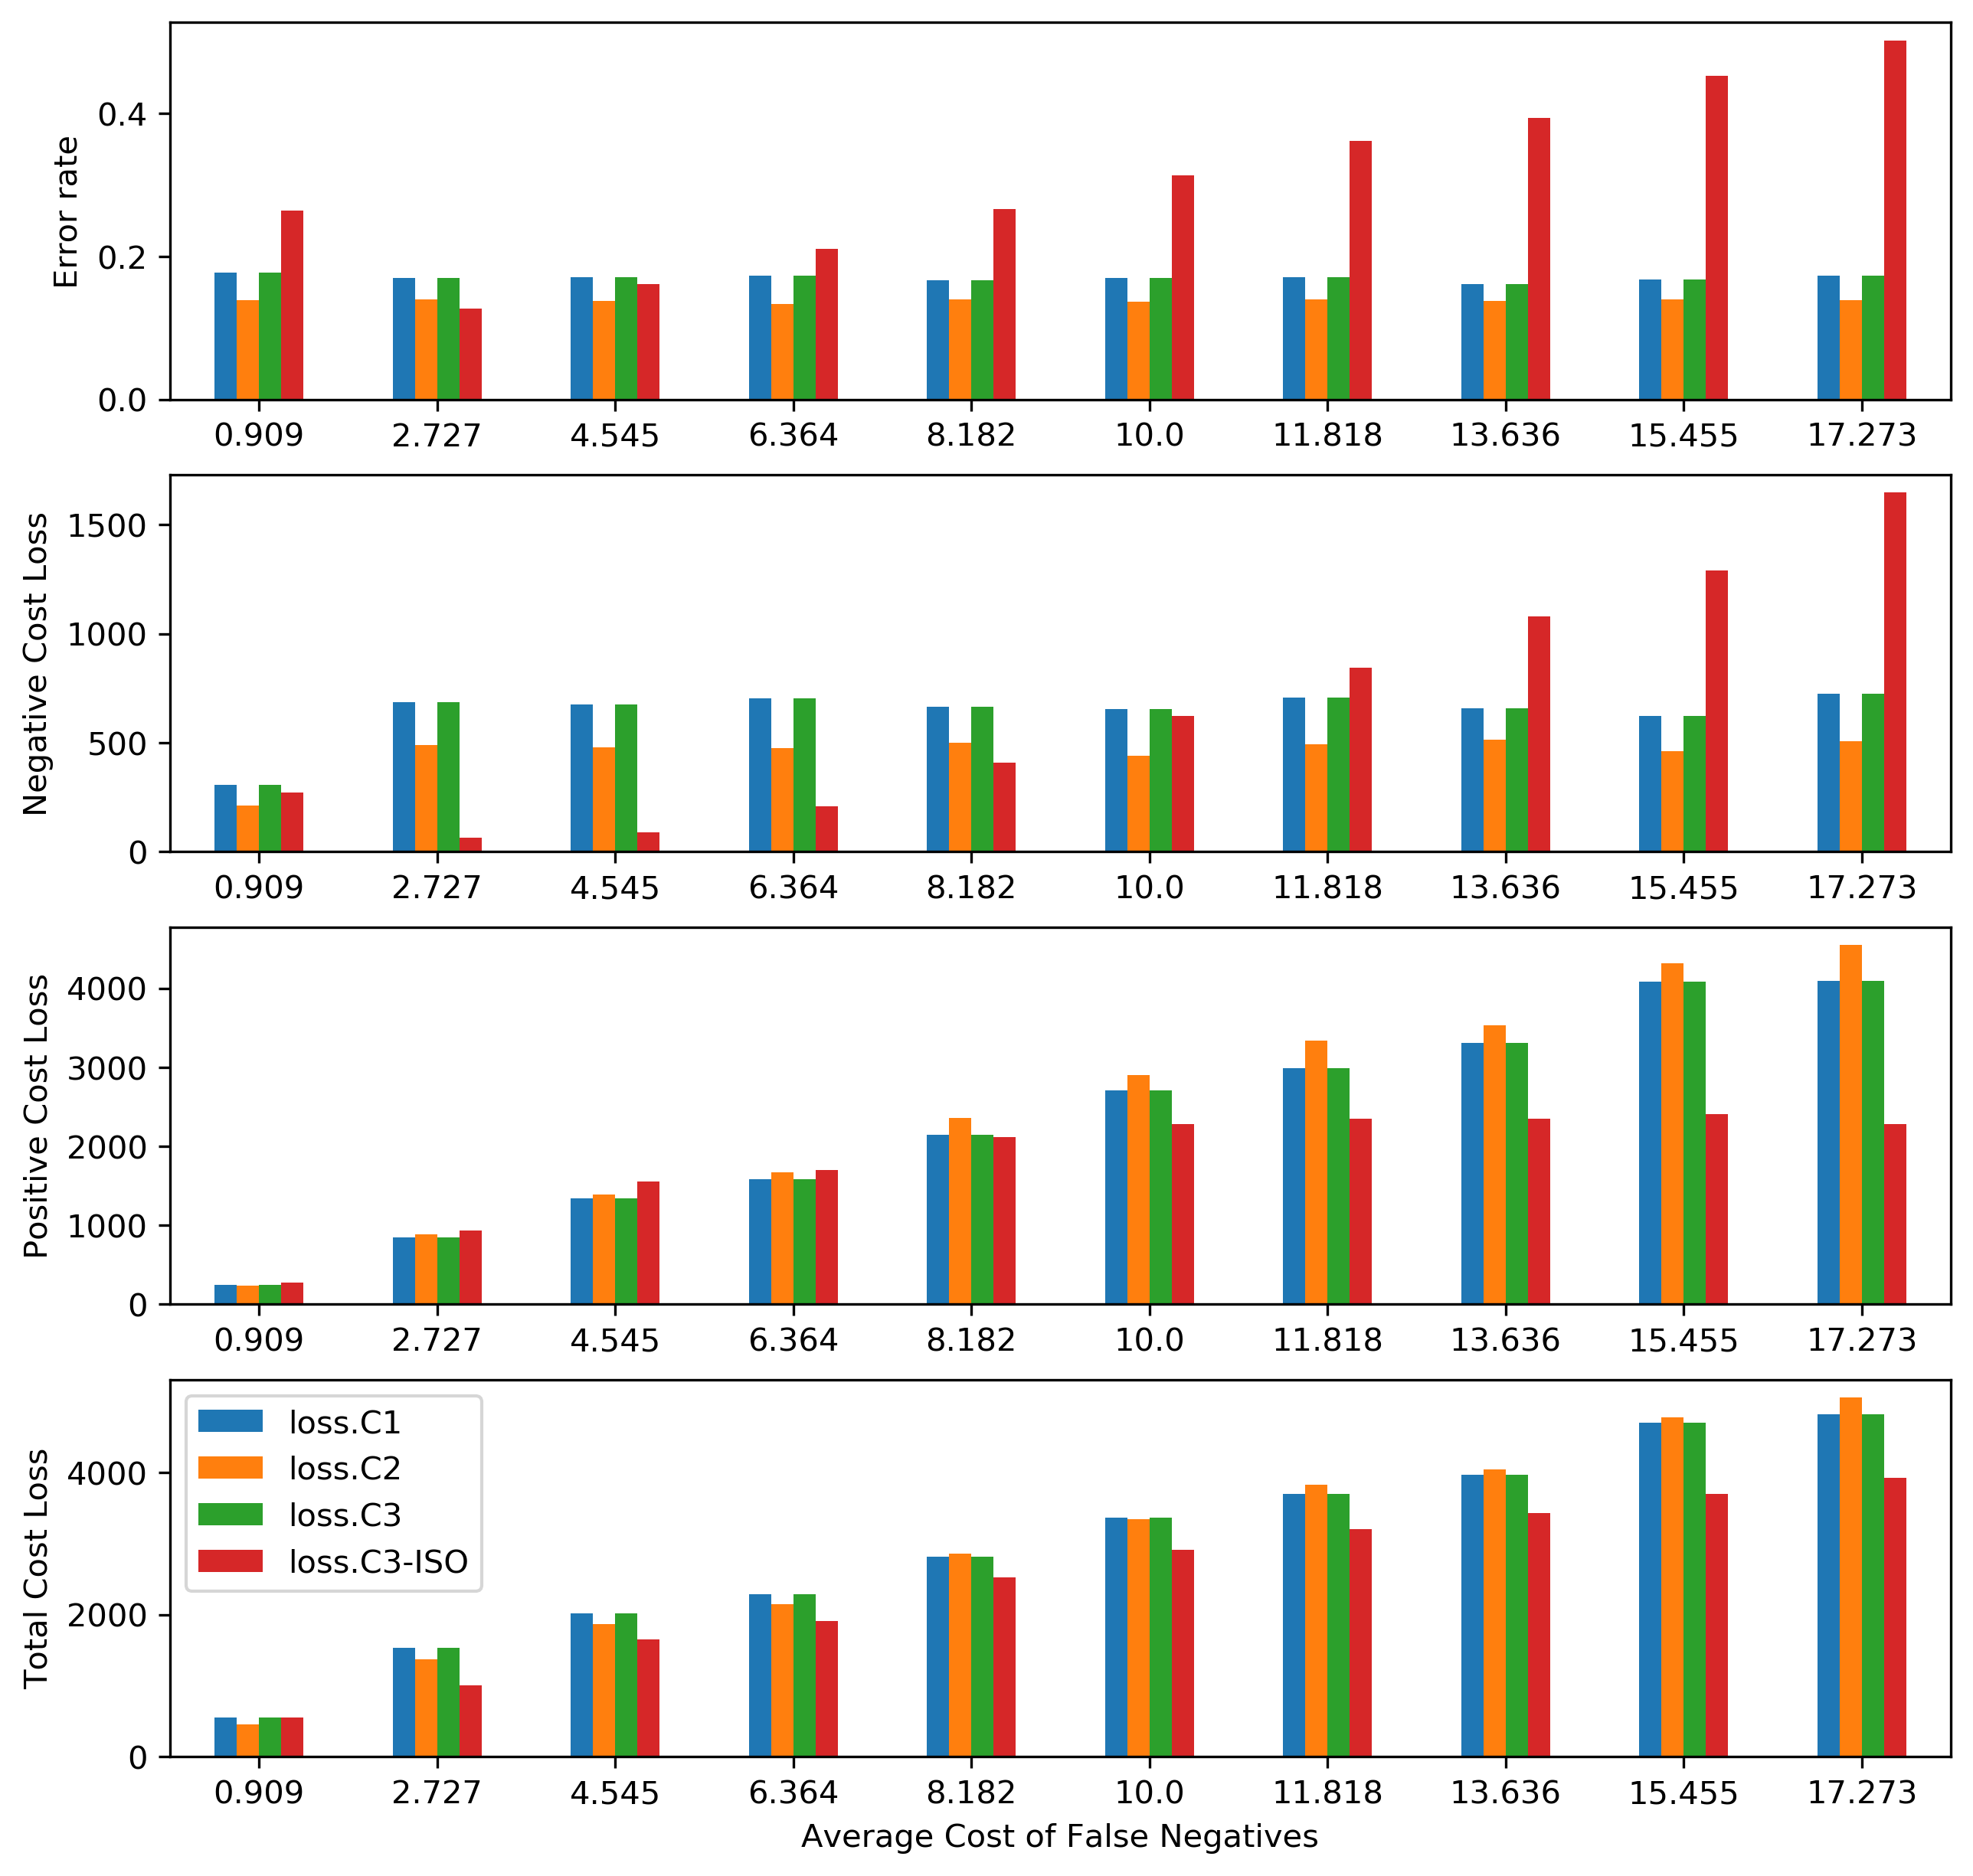

In [338]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize = (10,10), dpi = 300)

df_fig[['EDAB.C1','EDAB.C2','EDAB.C3', 'EDAB.C2-ROC']].plot.bar(rot = 0, ax=axes[0], legend=False)
axes[0].set(ylabel = 'Error rate', xlabel = ' ')

df_fig[['neg.C1','neg.C2','neg.C3', 'neg.C2-ROC']].plot.bar(rot = 0, ax=axes[1], legend = False)
axes[1].set(ylabel = 'Negative Cost Loss', xlabel = ' ')

df_fig[['pos.C1','pos.C2','pos.C3', 'pos.C2-ROC']].plot.bar(rot = 0, ax=axes[2], legend = False)
axes[2].set(ylabel = 'Positive Cost Loss', xlabel = ' ')

df_fig[['loss.C1','loss.C2','loss.C3', 'loss.C2-ROC']].plot.bar(rot = 0, ax=axes[3], legend = False)
axes[3].set(ylabel = 'Total Cost Loss', xlabel = 'Average Cost of False Negatives')

L=plt.legend()
L.get_texts()[3].set_text('loss.C3-ISO')

plt.savefig('Fig1.png', dpi=300)

#### Analysis - Ins Dataset

In [286]:
my_datasets[0]['cost_mat']

array([[ 1.39,  9.54,  2.06,  0.  ],
       [ 1.25, 13.83,  0.17,  0.  ],
       [ 1.28,  9.4 ,  1.96,  0.  ],
       ...,
       [ 1.45,  7.38,  0.34,  0.  ],
       [ 0.49,  8.46,  1.42,  0.  ],
       [ 1.39, 14.03,  1.43,  0.  ]])

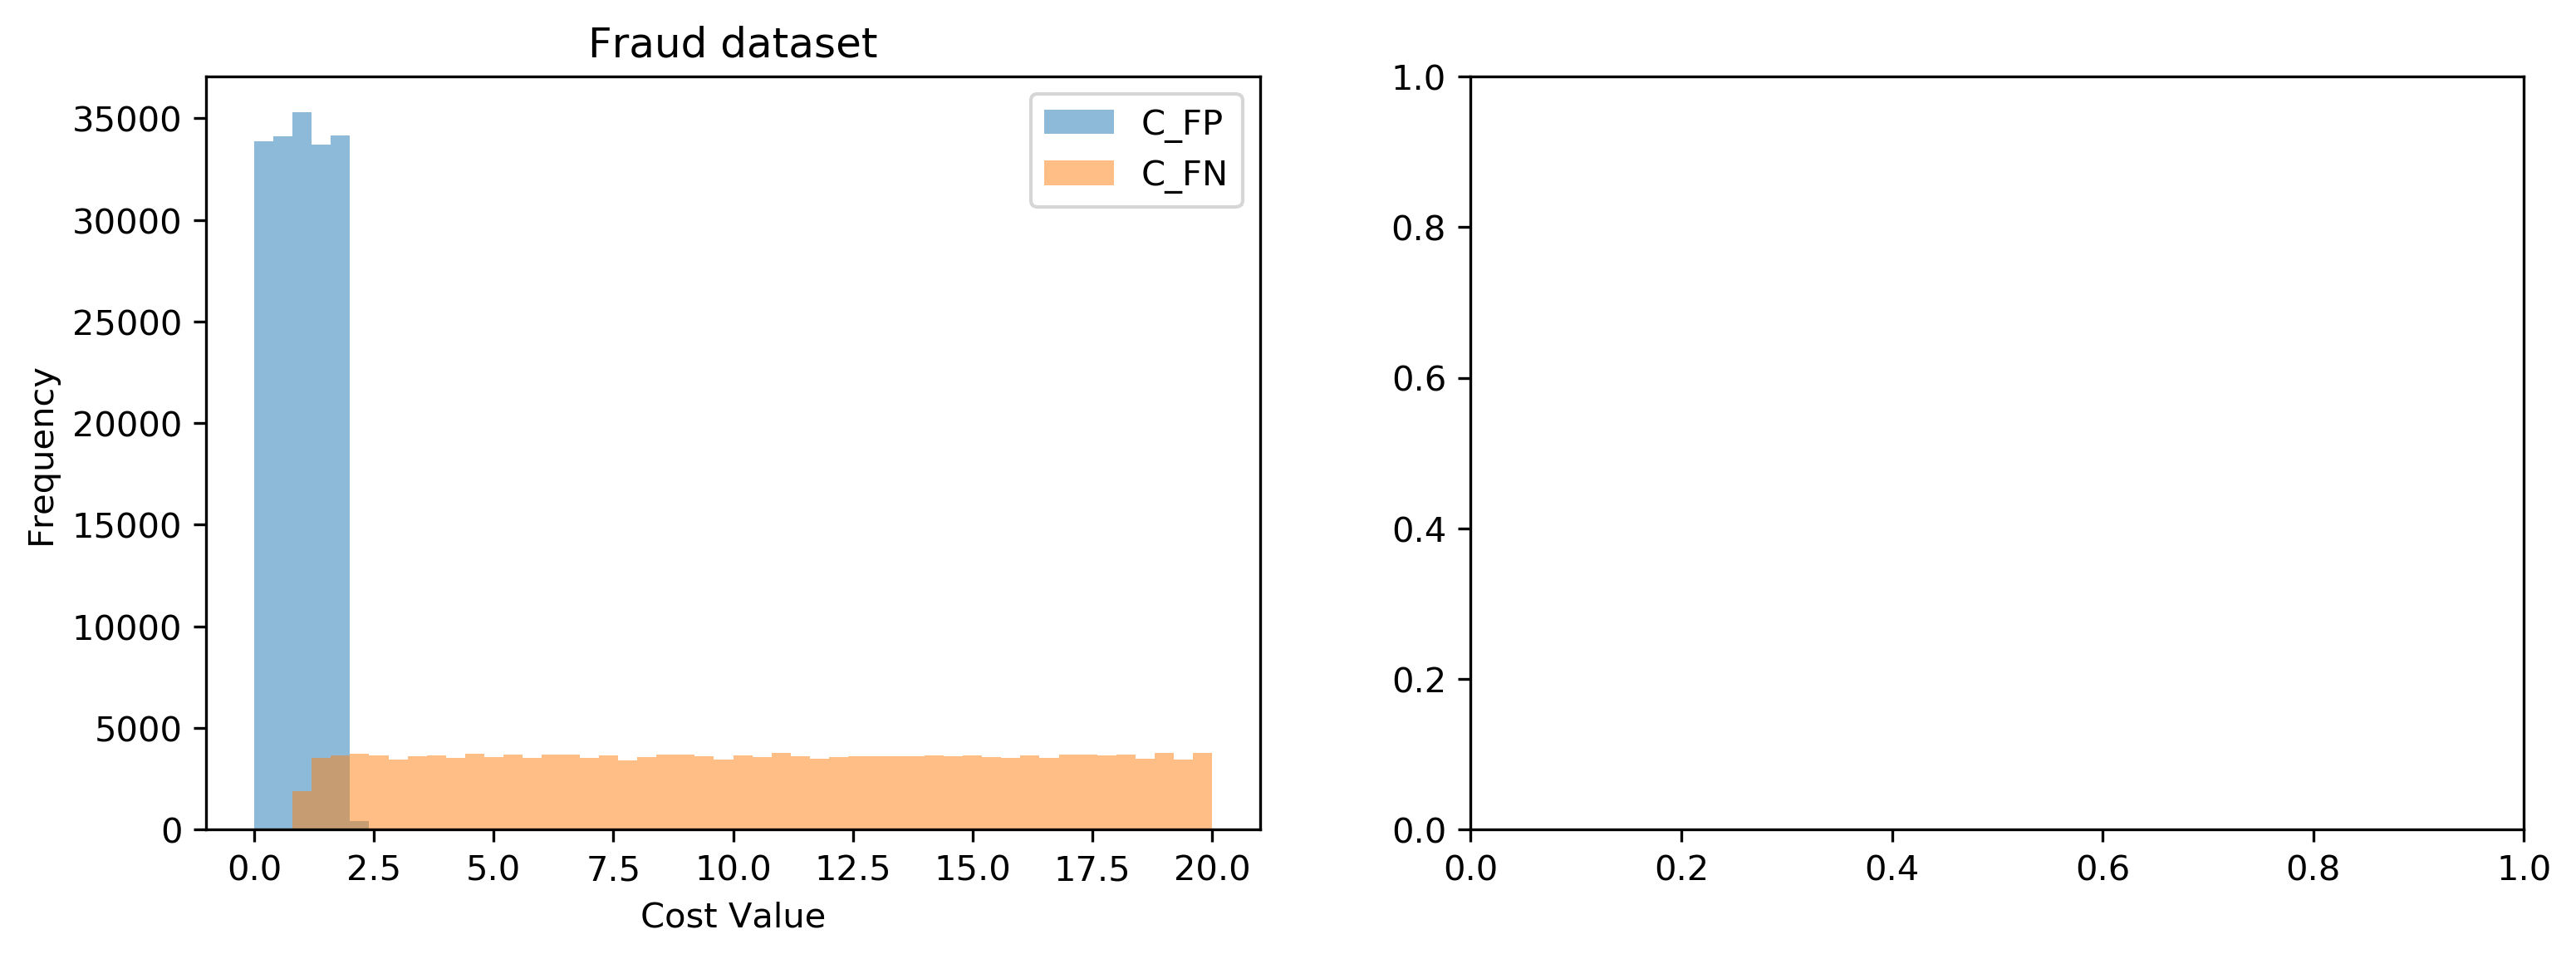

In [290]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,4), dpi = 300)

s1 = pd.DataFrame({'C_FP' : my_datasets[0]['cost_mat'][:,0], 'C_FN' : my_datasets[0]['cost_mat'][:,1]})
s1.plot.hist(bins=50, alpha=0.5, ax = axes[0])
axes[0].set(xlabel = 'Cost Value', title = 'Fraud dataset')

plt.savefig('Fig3.png', dpi=300)

In [292]:
print(s1.skew())

C_FP   -0.0029
C_FN   -0.0014
dtype: float64


### Functions

In [7]:
def cost_loss(y_true, y_pred, cost_mat):
    cost_N = (1 - y_true) * ((1 + y_pred) * cost_mat[:, 0] + (1 - y_pred) * cost_mat[:, 3]) / 4.0
    cost_P = (1 + y_true) * ((1 + y_pred) * cost_mat[:, 2] + (1 - y_pred) * cost_mat[:, 1]) / 4.0
    cost = cost_N + cost_P
    return [np.sum(cost), np.sum(cost_N), np.sum(cost_P)]

In [8]:
def savings_score(y_true, y_pred, cost_mat):
    n_samples = len(y_true)
    cost_base = min(cost_loss(y_true, np.ones(n_samples), cost_mat)[0],cost_loss(y_true, np.full(n_samples, -1.0), cost_mat)[0])
    cost = cost_loss(y_true, y_pred, cost_mat)[0]
    return 1.0 - cost / cost_base

In [9]:
def cost_confusion_matrix(y_true,y_pred,cost_mat):
    cost =  (1 - y_true) * ((1 + y_pred) * cost_mat[:, 0] + (1 - y_pred) * cost_mat[:, 3]) / 4.0
    cost += (1 + y_true) * ((1 + y_pred) * cost_mat[:, 2] + (1 - y_pred) * cost_mat[:, 1]) / 4.0
    TP,TN,FP,FN = 0.0,0.0,0.0,0.0
    for i in range(0,len(cost)):
        if y_pred[i] > 0:
            if y_true[i] > 0:
                TP += cost[i]
            else:
                FP += cost[i]
        else:
            if y_true[i] > 0:
                FN += cost[i]
            else:
                TN += cost[i]
    return np.array([[round(TN,3),round(FP,3)],[round(FN,3),round(TP,3)]])

In [10]:
def results(clf,X_train,y_train,cost_mat_train,X_test,y_test,cost_mat_test):
    pred_test  = clf.predict(X_test)
    pred_train = clf.predict(X_train)
    print('       Cost Savings Cost_N Cost_P')
    cost, cost_N, cost_P = cost_loss(y_train, pred_train, cost_mat_train)
    print('train: %.2f %.3f %.2f %.2f' %(cost, savings_score(y_train,pred_train,cost_mat_train), cost_N, cost_P))
    cost, cost_N, cost_P = cost_loss(y_test, pred_test, cost_mat_test)
    print('test : %.2f %.3f %.2f %.2f' %(cost, savings_score(y_test,pred_test,cost_mat_test), cost_N, cost_P))
    print(confusion_matrix(y_test,pred_test))
    print(cost_confusion_matrix(y_test,pred_test,cost_mat_test )) # / cost_mat_test.max()

In [11]:
def plot_history(clf):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(15, 5)
    df = pd.DataFrame()
    df['err_tot'] = clf.err_tot
    df['err_neg'] = clf.err_neg
    df['err_pos'] = clf.err_pos
    df['cost'] =    clf.costs
    df['cost_N'] =  clf.costs_N
    df['cost_P'] =  clf.costs_P
    df.err_tot.plot(legend = True, style='b', ax=axes[0])
    df.err_neg.plot(legend = True, style='r', ax=axes[0])
    df.err_pos.plot(legend = True, style='g', ax=axes[0])
    df.cost.plot(legend = True, style='b', ax=axes[1]) 
    df.cost_N.plot(legend = True, style='r', ax=axes[1])  
    df.cost_P.plot(legend = True, style='g', ax=axes[1]) 

In [12]:
class EDCS_AdaBoost():
    
    def __init__(self,base_estimator = None, n_estimators = 50, cost_func = 'CS1'):
        self.clf = base_estimator
        self.M = n_estimators
        self.clfs = []
        self.weights = []
        self.err_tot = []
        self.err_neg = []
        self.err_pos = []
        self.costs = []
        self.costs_N = []
        self.costs_P = []
        self.classes_ = [-1,1]
        if cost_func in ['CS1','CS2','CG1','CG2','C3']:
            self.cost_func = cost_func
        else:
            print("Available values of cost_func is 'CS1','CS2','CG1','CG2','C3'")
            sys.exit()
        
    def f2(self,beta,y,f,w,G):
        pos_mask = y > 0
        neg_mask = y < 0
        if self.cost_func == 'CG1':
            f1 = w * np.exp(-beta * y * G) * (1 + beta * G * self.D(y) / self.C(y,f))
        elif self.cost_func == 'CS1':
            f1 = w * np.exp(- beta * y * G * (self.C(y,f) + (f + beta * G) * self.D(y)))
        elif self.cost_func == 'CG2':
            f1 = np.zeros(len(y))
            f1[pos_mask] = w[pos_mask] * np.exp(-beta * G[pos_mask]) * (1 + beta * G[pos_mask] * self.D_pos(y) / self.C_pos(y,f))
            f1[neg_mask] = w[neg_mask] * np.exp( beta * G[neg_mask]) * (1 + beta * G[neg_mask] * self.D_neg(y) / self.C_neg(y,f))
        elif self.cost_func == 'CS2':
            f1 = np.zeros(len(y))
            f1[pos_mask] = w[pos_mask] * np.exp(-beta * G[pos_mask] * (self.C_pos(y,f) + self.D_pos(y) * (f[pos_mask] + beta * G[pos_mask])))
            f1[neg_mask] = w[neg_mask] * np.exp( beta * G[neg_mask] * (self.C_neg(y,f) + self.D_neg(y) * (f[neg_mask] + beta * G[neg_mask])))
        elif self.cost_func == 'C3':
            f1 = w * (self.C(y,f) + beta * G * self.D(y)) * np.exp(- beta * y * G * (self.C(y,f) + (f + beta * G) * self.D(y)))
        return f1.sum()
    
    def C(self,y,f):
        return ((1 + y) * ((1 + f) * self.C_TP + (1 - f) * self.C_FN) + (1 - y) * ((1 + f) * self.C_FP + (1 - f) * self.C_TN))/ 4.0
    
    def D(self,y):
        return ((1 + y) * (self.C_TP - self.C_FN) + (1 - y) * (self.C_FP - self.C_TN)) / 4.0
    
    def D_pos(self,y):
        pos_mask = y > 0
        return (self.C_TP[pos_mask] - self.C_FN[pos_mask]) / 2.0
    
    def D_neg(self,y):
        neg_mask = y < 0
        return (self.C_FP[neg_mask] - self.C_TN[neg_mask]) / 2.0
    
    def C_pos(self,y,f):
        pos_mask = y > 0
        return ((1 + f[pos_mask]) * self.C_TP[pos_mask] + (1 - f[pos_mask]) * self.C_FN[pos_mask]) / 2.0
    
    def C_neg(self,y,f):
        neg_mask = y < 0
        return ((1 + f[neg_mask]) * self.C_FP[neg_mask] + (1 - f[neg_mask]) * self.C_TN[neg_mask]) / 2.0
    
    def new_w(self,beta,y,G,w,f):
        pos_mask = y > 0
        neg_mask = y < 0
        if self.cost_func == 'CG1':
            w = w * np.exp(-beta * y * G) * (1 + beta * G * self.D(y) / self.C(y,f))
            w = w / sum(w)
        elif self.cost_func == 'CS1':
            w = w * np.exp(-beta * y * G * (self.C(y,f) + (f + beta * G) * self.D(y)))
            w = w / sum(w)
        elif self.cost_func == 'CG2':
            w[pos_mask] = w[pos_mask] * np.exp(-beta * G[pos_mask]) * (1 + beta * G[pos_mask] * self.D_pos(y) / self.C_pos(y,f))
            w[neg_mask] = w[neg_mask] * np.exp( beta * G[neg_mask]) * (1 + beta * G[neg_mask] * self.D_neg(y) / self.C_neg(y,f)) 
            w[pos_mask] = w[pos_mask]  / sum(w[pos_mask]) / 2 
            w[neg_mask] = w[neg_mask]  / sum(w[neg_mask]) / 2
        elif self.cost_func == 'CS2':
            w[pos_mask] = w[pos_mask] * np.exp(-beta * G[pos_mask] * (self.C_pos(y,f) + self.D_pos(y) * (f[pos_mask] + beta * G[pos_mask]))) 
            w[neg_mask] = w[neg_mask] * np.exp( beta * G[neg_mask] * (self.C_neg(y,f) + self.D_neg(y) * (f[neg_mask] + beta * G[neg_mask]))) 
            w[pos_mask] = w[pos_mask]  / sum(w[pos_mask]) / 2 
            w[neg_mask] = w[neg_mask]  / sum(w[neg_mask]) / 2
        elif self.cost_func == 'C3':
            w = w * np.exp(-beta * y * G * (self.C(y,f) + (f + beta * G) * self.D(y)))
            w = w / sum(w)
        return w
    
    def init_w(self,y):
        if self.cost_func == 'CS1' or self.cost_func == 'CG1' or self.cost_func == 'C3':
            return np.ones(len(y)) / len(y)
        elif self.cost_func == 'CS2' or self.cost_func == 'CG2':
            w = np.ones(len(y))
            pos_mask = y > 0
            neg_mask = y < 0
            w[pos_mask] = w[pos_mask] / sum(pos_mask) / 2
            w[neg_mask] = w[neg_mask] / sum(neg_mask) / 2
            return w
            
    def fit(self,X, y, cost_mat, verbose = False):
        cost_mat = cost_mat / cost_mat.max()
        self.C_FP = cost_mat[:,0] + 1.0
        self.C_FN = cost_mat[:,1] + 1.0
        self.C_TP = cost_mat[:,2] + 1.0
        self.C_TN = cost_mat[:,3] + 1.0
        
        ens = np.ones(len(y))      
        w = self.init_w(y)
        for i in range(self.M):
            f = ens
            self.clf.fit(X, y, sample_weight = np.array(w))     
            G = self.clf.predict(X)

            beta = fmin(self.f2,0.1,args = (y,f,w,G), disp = False)[0]   #self.f2 maybe returns something > 0.1 always
            
            if beta < 0.001:
                if verbose:
                    print('Stop! beta=%.3f' %beta)
                self.M = np.argmin(np.array(self.costs)) + 1
                break    
            self.clfs.append(deepcopy(self.clf))
            self.weights.append(beta)
            ens = f + beta * G
            pred = np.sign(ens)
            err_tot, err_neg, err_pos = get_error_rate(pred, y)
            cost, cost_N, cost_P = cost_loss(y, pred, cost_mat)
            savings = savings_score(y,pred,cost_mat)
            self.err_tot.append(err_tot)
            self.err_neg.append(err_neg)
            self.err_pos.append(err_pos)
            self.costs.append(cost)
            self.costs_N.append(cost_N)
            self.costs_P.append(cost_P)
            if verbose:
                print('%2d %0.3f %0.3f %0.3f %6.2f %6.3f %6.3f' %(i,err_tot,err_neg,err_pos,beta,savings, cost))               
            w = self.new_w(beta,y,G,w,f)
            
    def predict(self,X):
        pred = np.ones(len(X))
        for i in range(self.M):
            pred = pred + self.weights[i] * self.clfs[i].predict(X)
        return np.sign(pred)
    
    def predict_proba(self,X):
        proba = sum(c.predict_proba(X) * w for c, w in zip(self.clfs,self.weights))
        proba /= sum(self.weights)
        normalizer = proba.sum(axis=1)[:, np.newaxis]
        normalizer[normalizer == 0.0] = 1.0
        proba /= normalizer
        return proba
    
    def fit_BMR(self, X, y):
        from costcla.models import BayesMinimumRiskClassifier
        y_0 = np.array([1 if y > 0 else 0 for y in y])
        self.bmr = BayesMinimumRiskClassifier()
        self.bmr.fit(y_0, self.predict_proba(X))
        
    def predict_BMR(self, X, cost_mat):
        y_pred_0 = self.bmr.predict(self.predict_proba(X), cost_mat)
        y_pred_1 = np.array([1 if y > 0 else -1 for y in y_pred_0])
        return y_pred_1

In [202]:
def calibrate(clf, X_train, y_train, cost_mat_train, X_test, y_test, cost_mat_test, method = 'sigmoid'):
    cal_clf = CalibratedClassifierCV(clf, cv="prefit", method=method)
    start = time()
    cal_clf.fit(X_train, y_train)
    end = time()
                
    C_FP, C_FN, C_TP, C_TN = cost_mat_train[:,0], cost_mat_train[:,1], cost_mat_train[:,2], cost_mat_train[:,3]
    p_train = cal_clf.predict_proba(X_train)[:,1]
    exp_cost_pos = (1 - p_train) * C_FP + p_train * C_TP
    exp_cost_neg = (1 - p_train) * C_TN + p_train * C_FN
    y_pred_train = np.array([* map(lambda ecp,ecn: 1 if ecp < ecn else 0, exp_cost_pos,exp_cost_neg)])
                
    C_FP, C_FN, C_TP, C_TN = cost_mat_test[:,0], cost_mat_test[:,1], cost_mat_test[:,2], cost_mat_test[:,3]
    p_test = cal_clf.predict_proba(X_test)[:,1]
    exp_cost_pos = (1 - p_test) * C_FP + p_test * C_TP
    exp_cost_neg = (1 - p_test) * C_TN + p_test * C_FN
    y_pred_test = np.array([* map(lambda ecp,ecn: 1 if ecp < ecn else 0, exp_cost_pos,exp_cost_neg)])
                
    return end-start, y_pred_train, y_pred_test, p_train, p_test          

In [139]:
def post_proc(label, t, y_train, y_train_pred, cost_mat_train, y_test, y_test_pred, cost_mat_test):
    
    y_train = np.array([1 if y > 0 else 0 for y in y_train])
    y_test  = np.array([1 if y > 0 else 0 for y in y_test])
    y_train_pred = np.array([1 if y > 0 else 0 for y in y_train_pred])
    y_test_pred  = np.array([1 if y > 0 else 0 for y in y_test_pred])
    
    savings_train = cc.metrics.savings_score(y_train,y_train_pred,cost_mat_train)
    savings_test = cc.metrics.savings_score(y_test,y_test_pred,cost_mat_test)
    f1_test = f1_score(y_test,y_test_pred)
    
    print('%8s: %6.1f %6.3f %6.3f %6.3F' %(label, t, savings_train, savings_test, f1_test))
    
    res.append([label,t, savings_train, savings_test, f1_test]) 

In [212]:
def test_classifiers(datasets, 
                     my_algorithms, costcla_algorithms, costcla_labels, sk_algorithms, sk_labels,
                     my_BMR = False, costcla_BMR = False, sk_BMR = False,
                     my_Platt = False, costcla_Platt = False, sk_Platt = False,
                     my_Iso = False, costcla_Iso = False, sk_Iso = False):
 
    dt = DecisionTreeClassifier(max_depth = 1)

    out_scores_test = pd.DataFrame()
    out_scores_train = pd.DataFrame()
    
    print('Clf        Time  Train  Test      F1')
    for data in datasets:
        print(data['label'],'================================')
        X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = train_test_split(
                        data['X'], data['y'], data['cost_mat'], test_size=0.33, random_state=0)
        y_train_1 = np.array([1 if y > 0 else -1 for y in y_train])
        y_test_1  = np.array([1 if y > 0 else -1 for y in y_test])

        for cost in my_algorithms:
            edab = EDCS_AdaBoost(base_estimator = dt, n_estimators = 100, cost_func = cost)
            start = time()
            edab.fit(X_train, y_train_1, cost_mat_train, verbose = False)
            end = time()
            
            post_proc(cost, end-start, y_train_1, edab.predict(X_train), cost_mat_train, y_test_1, edab.predict(X_test), cost_mat_test)         

            if my_BMR:
                start = time()
                edab.fit_BMR(X_train, y_train_1)
                end = time()
                y_pred_test = edab.predict_BMR(X_test,cost_mat_test)
                y_pred_train = edab.predict_BMR(X_train,cost_mat_train)

                post_proc(cost+'-BMR', end-start, y_train_1, y_pred_train, cost_mat_train, 
                                                  y_test_1, y_pred_test, cost_mat_test)
            
            if my_Platt:
                t, y_pred_train, y_pred_test, p_train, p_test = calibrate(edab, X_train, y_train_1, cost_mat_train, X_test, y_test_1, cost_mat_test, method = 'sigmoid')
                
                out_scores_train[str(cost+'-BMR')] = p_train
                out_scores_test[str(cost+'-BMR')] = p_test
                
                post_proc(cost+'-Pla', end-start, y_train, y_pred_train, cost_mat_train, y_test, y_pred_test, cost_mat_test)

       
            if my_Iso:
                t, y_pred_train, y_pred_test, p_train, p_test = calibrate(edab, X_train, y_train_1, cost_mat_train, X_test, y_test_1, cost_mat_test, method = 'isotonic')

                out_scores_train[str(cost+'-Iso')] = p_train
                out_scores_test[str(cost+'-Iso')] = p_test
                
                post_proc(cost+'-Iso', end-start, y_train, y_pred_train, cost_mat_train, y_test, y_pred_test, cost_mat_test)


        for i,cc_alg in enumerate(costcla_algorithms):
            start = time()
            cc_alg.fit(X_train, y_train, cost_mat_train)
            end = time()
            
            post_proc(costcla_labels[i], end-start, y_train, cc_alg.predict(X_train), cost_mat_train, y_test, cc_alg.predict(X_test), cost_mat_test) 

            if costcla_BMR:
                cc_bmr = cc.models.BayesMinimumRiskClassifier()
                start = time()
                cc_bmr.fit(y_train, cc_alg.predict_proba(X_train))
                end = time()
                
                y_pred_train = cc_bmr.predict(cc_alg.predict_proba(X_train), cost_mat_train)
                y_pred_test = cc_bmr.predict(cc_alg.predict_proba(X_test), cost_mat_test)
                                
                post_proc(costcla_labels[i]+'-BMR', end-start, y_train, y_pred_train, cost_mat_train, 
                                                               y_test,  y_pred_test, cost_mat_test)
              
            if costcla_Platt:
                t, y_pred_train, y_pred_test, p_train, p_test = calibrate(cc_alg, X_train, y_train, cost_mat_train, X_test, y_test, cost_mat_test, method = 'sigmoid')
                
                out_scores_train[str(costcla_labels[i]+'-Pla')] = p_train
                out_scores_test[str(costcla_labels[i]+'-Pla')] = p_test
                
                post_proc(costcla_labels[i]+'-Pla', end-start, y_train, y_pred_train, cost_mat_train, y_test,  y_pred_test, cost_mat_test)
            
            if costcla_Iso:
                t, y_pred_train, y_pred_test, p_train, p_test = calibrate(cc_alg, X_train, y_train, cost_mat_train, X_test, y_test, cost_mat_test, method = 'isotonic')
                
                out_scores_train[str(costcla_labels[i]+'-Iso')] = p_train
                out_scores_test[str(costcla_labels[i]+'-Iso')] = p_test
                
                post_proc(costcla_labels[i]+'-Iso', end-start, y_train, y_pred_train, cost_mat_train, y_test,  y_pred_test, cost_mat_test)

        
        for i, clf in enumerate(sk_algorithms):
            start =time()
            clf.fit(X_train,y_train)
            end = time()
            
            post_proc(sk_labels[i], end-start, y_train, clf.predict(X_train), cost_mat_train, y_test,  clf.predict(X_test), cost_mat_test)

            if sk_BMR:
                clf_bmr = cc.models.BayesMinimumRiskClassifier()
                start = time()
                clf_bmr.fit(y_train, clf.predict_proba(X_train))
                end = time()
                
                y_pred_train = clf_bmr.predict(clf.predict_proba(X_train), cost_mat_train)
                y_pred_test = clf_bmr.predict(clf.predict_proba(X_test), cost_mat_test)
                
                
                post_proc(sk_labels[i]+'-BMR', end-start, y_train, y_pred_train, cost_mat_train, 
                                                          y_test, y_pred_test, cost_mat_test)

                
            if sk_Platt:
                t, y_pred_train, y_pred_test, p_train, p_test = calibrate(clf, X_train, y_train, cost_mat_train, X_test, y_test, cost_mat_test, method = 'sigmoid')
                
                out_scores_train[str(sk_labels[i]+'-Pla')] = p_train
                out_scores_test[str(sk_labels[i]+'-Pla')] = p_test
                
                post_proc(sk_labels[i]+'-Pla', end-start, y_train, y_pred_train, cost_mat_train, y_test,  y_pred_test, cost_mat_test)
                
            
            if sk_Iso:
                t, y_pred_train, y_pred_test, p_train, p_test = calibrate(cc_alg, X_train, y_train, cost_mat_train, X_test, y_test, cost_mat_test, method = 'isotonic')
                
                out_scores_train[str(sk_labels[i]+'-Iso')] = p_train
                out_scores_test[str(sk_labels[i]+'-Iso')] = p_test
                
                post_proc(sk_labels[i]+'-Iso', end-start, y_train, y_pred_train, cost_mat_train, y_test,  y_pred_test, cost_mat_test)
    return out_scores_test, out_scores_train

In [265]:
def get_error_rate(pred, Y):
    pos_mask = Y > 0
    neg_mask = Y < 0
    err_neg = sum(pred[neg_mask] != Y[neg_mask]) / float(sum(neg_mask))
    err_pos = sum(pred[pos_mask] != Y[pos_mask]) / float(sum(pos_mask))
    err_tot = sum(pred != Y) / float(len(Y)) 
    return err_tot, err_neg, err_pos